c:\Users\fernando berumen\Documents\Python Scripts\trading_spot\venv311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


⏰ Última vela analizada: 2025-09-26 20:00:00 UTC
📈 Predicción dirección siguiente vela: Alta ↑
💹 Precio estimado cierre: 109495.8283
🕯 Patrón de la última vela: Normal


C:\Users\fernando berumen\AppData\Local\Temp\ipykernel_25128\3854847478.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred_close"] = preds
C:\Users\fernando berumen\AppData\Local\Temp\ipykernel_25128\3854847478.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred_direction"] = np.where(df["pred_close"]>df["close"], "Alta ↑", "Baja ↓")
C:\Users\fernando berumen\AppData\Local\Temp\ipykernel_25128\3854847478.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

📊 Backtesting: precisión en dirección: 86.03%
💰 Capital final: 35143.16 USD
📉 Drawdown máximo: 3399.39 USD


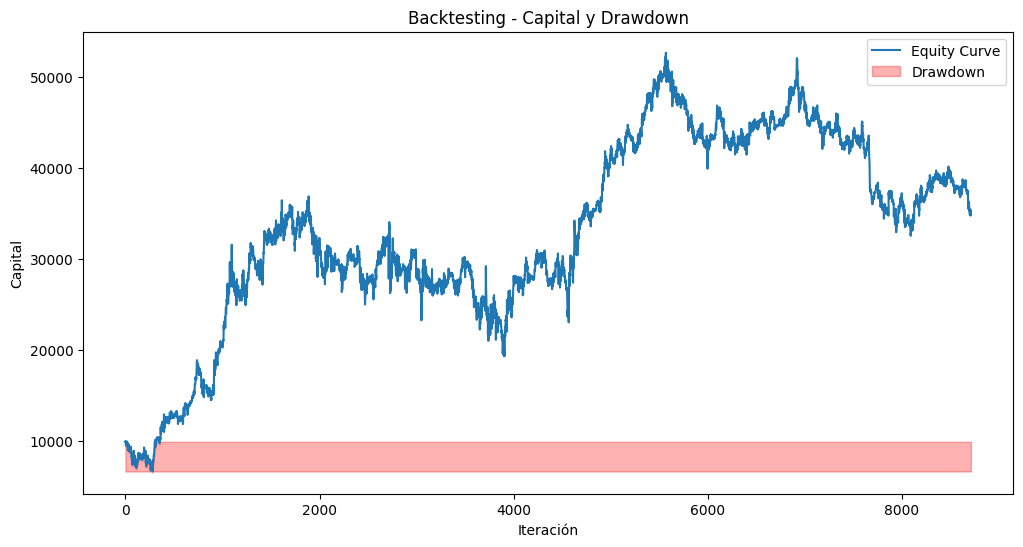

In [ ]:
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# ======================
# Configuración global
# ======================
SYMBOL = "BTCUSDT"
INTERVAL = "1h"
DAYS = 365
RANDOM_STATE = 42
capital_inicial = 10000
capital = capital_inicial
equity_curve = []
drawdowns = []

# ======================
# 1️⃣ Descargar OHLCV
# ======================
def get_binance_ohlcv(symbol=SYMBOL, interval=INTERVAL, days=DAYS):
    base_url = "https://api.binance.com/api/v3/klines"
    limit = 1000
    ms_interval = 60*60*1000
    end_time = int(time.time()*1000)
    start_time = end_time - days*24*60*60*1000
    all_data = []
    
    while start_time < end_time:
        params = {"symbol": symbol, "interval": interval, "startTime": start_time, "limit": limit}
        resp = requests.get(base_url, params=params)
        data = resp.json()
        if not data: break
        all_data.extend(data)
        last_open_time = data[-1][0]
        start_time = last_open_time + ms_interval
        time.sleep(0.2)
    
    df = pd.DataFrame(all_data, columns=["open_time","open","high","low","close","volume",
                                         "close_time","quote_asset_volume","number_of_trades",
                                         "taker_buy_base","taker_buy_quote","ignore"])
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    for col in ["open","high","low","close","volume"]: df[col] = df[col].astype(float)
    return df[["open_time","open","high","low","close","volume"]]

# ======================
# 2️⃣ Indicadores
# ======================
def compute_features(df):
    df["return"] = df["close"].pct_change()
    df["volatility"] = df["return"].rolling(10).std()
    df["ma_10"] = df["close"].rolling(10).mean()
    df["ma_50"] = df["close"].rolling(50).mean()
    df["rsi"] = compute_rsi(df["close"])
    df.dropna(inplace=True)
    return df

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta>0, delta, 0)
    loss = np.where(delta<0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(period).mean()
    avg_loss = pd.Series(loss).rolling(period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100 - (100/(1+rs))

# ======================
# 3️⃣ Patrón de velas
# ======================
def detect_candle_pattern(row):
    body = abs(row["close"] - row["open"])
    upper_shadow = row["high"] - max(row["open"], row["close"])
    lower_shadow = min(row["open"], row["close"]) - row["low"]
    if body < 0.25*(row["high"]-row["low"]) and lower_shadow > 2*body:
        return "Martillo ↑ (posible rebote alcista)"
    elif body < 0.25*(row["high"]-row["low"]) and upper_shadow > 2*body:
        return "Martillo invertido ↓ (posible reversa bajista)"
    elif body < 0.1*(row["high"]-row["low"]):
        return "Doji (indecisión)"
    else:
        return "Normal"

# ======================
# 4️⃣ Entrenamiento y predicción
# ======================
def train_predict(df):
    features = ["return","volatility","ma_10","ma_50","rsi"]
    X = df[features]
    y = df["close"].shift(-1)[:-1]
    X = X[:-1]
    df = df[:-1]
    
    model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X, y)
    
    last_features = X.iloc[-1].values.reshape(1,-1)
    pred_close = model.predict(last_features)[0]
    
    last_row = df.iloc[-1]
    direction = "Alta ↑" if pred_close > last_row["close"] else "Baja ↓"
    pattern = detect_candle_pattern(last_row)
    
    return {
        "datetime": last_row["open_time"],
        "last_close": last_row["close"],
        "pred_close": pred_close,
        "direction": direction,
        "pattern": pattern
    }

# ======================
# 5️⃣ Backtesting
# ======================
def backtest(df):
    global capital
    features = ["return","volatility","ma_10","ma_50","rsi"]
    X = df[features]
    y = df["close"].shift(-1)[:-1]
    X = X[:-1]
    df = df[:-1]
    
    model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X, y)
    
    preds = model.predict(X)
    df["pred_close"] = preds
    df["pred_direction"] = np.where(df["pred_close"]>df["close"], "Alta ↑", "Baja ↓")
    df["hit_direction"] = df["pred_direction"] == np.where(df["close"].shift(-1)>df["close"], "Alta ↑", "Baja ↓")
    accuracy = df["hit_direction"].mean()
    
    # Simular capital
    for i, row in df.iterrows():
        pnl = row["pred_close"] - row["close"]
        capital += pnl
        equity_curve.append(capital)
        drawdowns.append(capital_inicial - capital if capital < capital_inicial else 0)
    
    return df, accuracy

# ======================
# 6️⃣ Ejecutar
# ======================
df = get_binance_ohlcv(SYMBOL, INTERVAL, DAYS)
df = compute_features(df)

# Predicción siguiente vela
result = train_predict(df)
print("============================================")
print(f"⏰ Última vela analizada: {result['datetime']} UTC")
print(f"📈 Predicción dirección siguiente vela: {result['direction']}")
print(f"💹 Precio estimado cierre: {result['pred_close']:.4f}")
print(f"🕯 Patrón de la última vela: {result['pattern']}")
print("============================================")

# Backtesting
df_backtest, accuracy = backtest(df)
print(f"📊 Backtesting: precisión en dirección: {accuracy*100:.2f}%")
print(f"💰 Capital final: {capital:.2f} USD")
print(f"📉 Drawdown máximo: {max(drawdowns):.2f} USD")


